In [1]:
import sys
sys.path.append(r"scripts")
from functools import lru_cache
import pandas as pd
import numpy as np
import torch


# Check if PyTorch is installed
print(f"PyTorch version: {torch.__version__}")

print(torch.version.cuda)  # Should match 12.6 or similar
print(torch.backends.cudnn.enabled)  # Sho
from torch_geometric.data import Data
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import os
import requests
import zipfile
import networkx as nx
import scripts
from scripts import *
import torchmetrics
from torch import nn
import optuna
import models
from optuna.integration import TensorBoardCallback
from model_GNN import ModularPathwayConv, ModularGNN
torch.set_printoptions(threshold=torch.inf)
from model_ResNet import CombinedModel, ResNet, DrugMLP  
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from copy import deepcopy
import itertools
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1e6} MB")
print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / 1e6} MB")
import uuid
import torch.nn.functional as F 

PyTorch version: 2.5.1.post106
None
True
Memory allocated: 0.0 MB
Max memory allocated: 0.0 MB


In [1]:
@lru_cache(maxsize=None)
def get_data(n_fold=0, fp_radius=2):
    """Download, process, and prepare data for use in graph-based machine learning models."""
    import os
    import zipfile
    import requests
    import torch
    import pandas as pd
    import numpy as np
    import networkx as nx
    from torch_geometric.data import Data
    import scripts  # Assuming scripts has required functions

    def download_if_not_present(url, filepath):
        """Download a file from a URL if it does not exist locally."""
        if not os.path.exists(filepath):
            print(f"File not found at {filepath}. Downloading...")
            response = requests.get(url, stream=True)
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            with open(filepath, "wb") as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            print("Download completed.")
        else:
            print(f"File already exists at {filepath}.")

    # Step 1: Download and load RNA-seq data
    zip_url = "https://cog.sanger.ac.uk/cmp/download/rnaseq_all_20220624.zip"
    zip_filepath = "data/rnaseq.zip"
    rnaseq_filepath = "data/rnaseq_normcount.csv"
    if not os.path.exists(rnaseq_filepath):
        download_if_not_present(zip_url, zip_filepath)
        with zipfile.ZipFile(zip_filepath, "r") as zipf:
            zipf.extractall("data/")
    rnaseq = pd.read_csv(rnaseq_filepath, index_col=0)

    # Step 2: Load gene network, hierarchies, and driver genes
    hierarchies = pd.read_csv("data/gene_to_pathway_final_with_hierarchy.csv")
    driver_genes = pd.read_csv("data/driver_genes_2.csv")['gene'].dropna()
    gene_network = nx.read_edgelist("data/filtered_gene_network.edgelist", nodetype=str)
    ensembl_to_hgnc = dict(zip(hierarchies['Ensembl_ID'], hierarchies['HGNC']))
    mapped_gene_network = nx.relabel_nodes(gene_network, ensembl_to_hgnc)

    # Step 3: Filter RNA-seq data and identify valid nodes
    driver_columns = rnaseq.columns.isin(driver_genes)
    filtered_rna = rnaseq.loc[:, driver_columns]
    valid_nodes = set(filtered_rna.columns)  # Get valid nodes after filtering RNA-seq columns

    # Step 4: Create edge tensors for the graph
    edges_df = pd.DataFrame(
        list(mapped_gene_network.edges(data="weight")),
        columns=["source", "target", "weight"]
    )
    edges_df["weight"] = edges_df["weight"].fillna(1.0).astype(float)
    filtered_edges = edges_df[
        (edges_df["source"].isin(valid_nodes)) & (edges_df["target"].isin(valid_nodes))
    ]
    node_to_idx = {node: idx for idx, node in enumerate(valid_nodes)}
    filtered_edges["source_idx"] = filtered_edges["source"].map(node_to_idx)
    filtered_edges["target_idx"] = filtered_edges["target"].map(node_to_idx)
    edge_index = torch.tensor(filtered_edges[["source_idx", "target_idx"]].values.T, dtype=torch.long)
    edge_attr = torch.tensor(filtered_edges["weight"].values, dtype=torch.float32)

    # Step 5: Process the hierarchy to create pathway groups
    filtered_hierarchy = hierarchies[hierarchies["HGNC"].isin(valid_nodes)]
    pathway_dict = {
        gene: pathway.split(':', 1)[1].split('[', 1)[0].strip() if isinstance(pathway, str) and ':' in pathway else None
        for gene, pathway in zip(filtered_hierarchy['HGNC'], filtered_hierarchy['Level_1'])
    }
    grouped_pathway_dict = {}
    for gene, pathway in pathway_dict.items():
        if pathway:
            grouped_pathway_dict.setdefault(pathway, []).append(gene)
    pathway_groups = {
        pathway: [node_to_idx[gene] for gene in genes if gene in node_to_idx]
        for pathway, genes in grouped_pathway_dict.items()
    }
    # Convert to padded tensor
    pathway_tensors = pad_sequence(
        [torch.tensor(indices, dtype=torch.long) for indices in pathway_groups.values()], 
        batch_first=True, 
        padding_value=-1  # Use -1 as padding
    )

    # Step 6: Create cell-line graphs
    tensor_exp = torch.tensor(filtered_rna.to_numpy())
    cell_dict = {cell: tensor_exp[i] for i, cell in enumerate(filtered_rna.index.to_numpy())}
    graph_data_list = {}
    for cell, x in cell_dict.items():
        if x.ndim == 2 and x.shape[0] == 1:
            x = x.T
        elif x.ndim == 1:
            x = x.unsqueeze(1)
        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        graph_data.y = None
        graph_data.cell_line = cell
        graph_data_list[cell] = graph_data

    # Step 7: Load drug data
    smile_dict = pd.read_csv("data/smiles.csv", index_col=0)
    fp = scripts.FingerprintFeaturizer(R=fp_radius)
    drug_dict = fp(smile_dict.iloc[:, 1], smile_dict.iloc[:, 0])

    # Step 8: Load IC50 data and filter for valid cell lines and drugs
    data = pd.read_csv("data/GDSC1.csv", index_col=0)
    data = data.query("SANGER_MODEL_ID in @cell_dict.keys() & DRUG_ID in @drug_dict.keys()")

    # Step 9: Split the data into folds for cross-validation
    unique_cell_lines = data["SANGER_MODEL_ID"].unique()
    np.random.seed(420)
    np.random.shuffle(unique_cell_lines)
    folds = np.array_split(unique_cell_lines, 10)
    train_idxs = list(range(10))
    train_idxs.remove(n_fold)
    validation_idx = np.random.choice(train_idxs)
    train_idxs.remove(validation_idx)
    train_lines = np.concatenate([folds[idx] for idx in train_idxs])
    validation_lines = folds[validation_idx]
    test_lines = folds[n_fold]

    train_data = data.query("SANGER_MODEL_ID in @train_lines")
    validation_data = data.query("SANGER_MODEL_ID in @validation_lines")
    test_data = data.query("SANGER_MODEL_ID in @test_lines")

    # Step 10: Build the datasets for training, validation, and testing
    train_dataset = scripts.OmicsDataset(graph_data_list, drug_dict, train_data)
    validation_dataset = scripts.OmicsDataset(graph_data_list, drug_dict, validation_data)
    test_dataset = scripts.OmicsDataset(graph_data_list, drug_dict, test_data)

    return train_dataset, validation_dataset, test_dataset, pathway_tensors


NameError: name 'lru_cache' is not defined

In [ ]:
train_graphs, val_graphs, test_graphs, pathway_tensors = get_data(n_fold=0)

In [ ]:
from torch_geometric.loader import DataLoader

# Create a DataLoader for training graphs
batch_size = 2  # Adjust based on memory and dataset size
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)


In [2]:
# Configuration for the GNN
config = {
    "gnn": {
        "input_dim": 1,  # Adjust based on your dataset
        "hidden_dim": 128,
        "output_dim": 1,  # Adjust based on your dataset
        "pathway_groups": None,  # Predefined pathway_groups tensor
        "layer_modes": [True, True, True],  # Specify global or pathway-specific modes
        "pooling_mode": "pathway",  # Pooling mode for final embeddings
        "aggr_modes": ["sum", "max", "mean"],  # Aggregation methods per layer
        "num_pathways_per_instance": 2
    }
}

# Initialize the model using the config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModularGNN(
    input_dim=config["gnn"]["input_dim"],
    hidden_dim=config["gnn"]["hidden_dim"],
    output_dim=config["gnn"]["output_dim"],
    #pathway_groups=config["gnn"]["pathway_groups"],
    layer_modes=config["gnn"]["layer_modes"],
    aggr_modes=config["gnn"]["aggr_modes"],
    pooling_mode=config["gnn"]["pooling_mode"],
    num_pathways_per_instance=config["gnn"]["num_pathways_per_instance"]
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


2
Initialized with 'sum' string-based aggregator
2
Initialized with 'max' string-based aggregator
2
Initialized with 'mean' string-based aggregator


In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch + 1}/{epochs} started...")
    for batch_idx, batch in enumerate(train_loader):
        try:
            # Unpack batch components
            cell_graph_batch, drug_tensor_batch, target_batch, cell_id_batch, drug_id_batch = batch
        except Exception as e:
            print(f"Error unpacking batch {batch_idx}: {e}")
            print(f"Batch contents: {batch}")
            continue

        # Extract node features (x) and other components
        cell_graph = cell_graph_batch.to(device)  # PyG Data object for the cell graph
        x = cell_graph.x  # Extract node features
        edge_index = cell_graph.edge_index  # Extract edge indices
        edge_attr = cell_graph.edge_attr if hasattr(cell_graph, "edge_attr") else None  # Extract edge attributes
        drug_vector = drug_tensor_batch.to(device)  # Tensor for drug features
        targets = target_batch.to(device)  # Tensor for target outputs

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            pathway_tensor=config["gnn"]["pathway_groups"],  # Pathway tensor
            batch=cell_graph.batch  # Batch information for pooling
        )
        print(f"output shape:{outputs.shape}")
        # Loss computation
        loss = F.mse_loss(outputs.squeeze(), targets.squeeze())  # Example: regression loss
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Feedback for each batch
        print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    # Feedback after each epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs} completed. Average Loss: {avg_loss:.4f}")

tensor([[ 2,  1, -1],
        [ 0, -1, -1],
        [ 0,  2, -1],
        [ 1, -1, -1]])


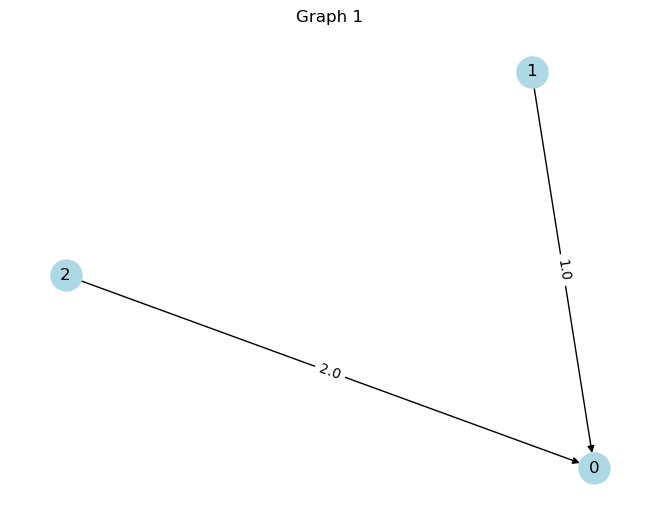

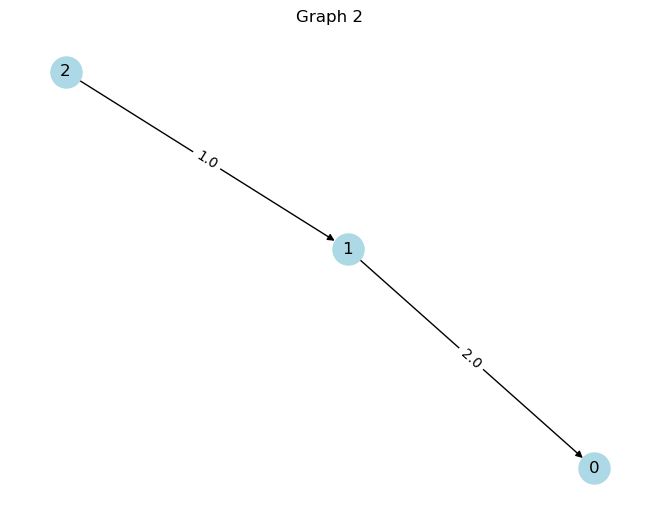

Batch node features:
tensor([[1.],
        [2.],
        [2.],
        [5.],
        [2.],
        [5.]])
Batch edge index:
tensor([[1, 2, 4, 5],
        [0, 0, 3, 4]])
Batch edge attributes:
tensor([1., 2., 2., 1.])
Batch pathways:
tensor([[ 2,  1, -1],
        [ 0, -1, -1],
        [ 0,  2, -1],
        [ 1, -1, -1]])
Batch assignment:
tensor([0, 0, 0, 1, 1, 1])


In [9]:
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# Define node features and edge index for two graphs
x1 = torch.tensor([[1.0], [2.0], [2.0]])  # Node features for graph 1
edge_index1 = torch.tensor([[ 1, 2],  # Source nodes
                            [0, 0]])  # Target nodes
edge_attr1 = torch.tensor([ 1.0, 2.0])  # Edge attributes for graph 1

x2 = torch.tensor([[5.0], [2.0], [5.0]])  # Node features for graph 2
edge_index2 = torch.tensor([[ 1, 2],  # Source nodes
                            [ 0, 1]])  # Target nodes
edge_attr2 = torch.tensor([ 2.0, 1.0])  # Edge attributes for graph 2

# Define pathways
# Pathway tensor for Graph 1
pathway_tensor1 = torch.tensor([
    [2, 1, -1],  # Pathway 1 (nodes 0 and 1)
    [0, -1, -1]  # Pathway 2 (node 2)
], dtype=torch.long)

# Pathway tensor for Graph 2
pathway_tensor2 = torch.tensor([
    [0, 2, -1],  # Pathway 1 (nodes 0 and 2)
    [1, -1, -1]  # Pathway 2 (node 1)
], dtype=torch.long)

# Create Data objects for each graph
data1 = Data(x=x1, edge_index=edge_index1, edge_attr=edge_attr1,pathway_tensor = pathway_tensor1)
data2 = Data(x=x2, edge_index=edge_index2, edge_attr=edge_attr2,pathway_tensor = pathway_tensor2)



# Batch the data
batch = Batch.from_data_list([data1, data2])
print(batch.pathway_tensor)


# Visualize the graphs
def visualize_graph(data, title):
    G = to_networkx(data, edge_attrs=["edge_attr"])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["edge_attr"]}' for u, v, d in G.edges(data=True)})
    plt.title(title)
    plt.show()

visualize_graph(data1, "Graph 1")
visualize_graph(data2, "Graph 2")

# Check batch
print(f"Batch node features:\n{batch.x}")
print(f"Batch edge index:\n{batch.edge_index}")
print(f"Batch edge attributes:\n{batch.edge_attr}")
print(f"Batch pathways:\n{batch.pathway_tensor}")
print(f"Batch assignment:\n{batch.batch}")

In [10]:
# Extract components from the batch
x = batch.x
edge_index = batch.edge_index
edge_attr = batch.edge_attr
pathway_tensor = batch.pathway_tensor  # Pathway tensor
batch_assignment = batch.batch  # Batch assignment vector
print(pathway_tensor)
# Forward pass through the model
outputs = model(
    x=x,
    edge_index=edge_index,
    edge_attr=edge_attr,
    pathway_tensor=pathway_tensor,
    batch=batch_assignment
)

tensor([[ 2,  1, -1],
        [ 0, -1, -1],
        [ 0,  2, -1],
        [ 1, -1, -1]])
shifted pathway_groups:tensor([[ 2,  1, -1],
        [ 0, -1, -1],
        [ 3,  5, -1],
        [ 4, -1, -1]])
x_updated[nodes]:tensor([[1.],
        [2.],
        [2.],
        [5.],
        [2.],
        [5.]])
shifted pathway_groups:tensor([[ 2,  1, -1],
        [ 0, -1, -1],
        [ 3,  5, -1],
        [ 4, -1, -1]])
x_updated[nodes]:tensor([[1.],
        [2.],
        [2.],
        [5.],
        [2.],
        [5.]])
shifted pathway_groups:tensor([[ 2,  1, -1],
        [ 0, -1, -1],
        [ 3,  5, -1],
        [ 4, -1, -1]])
x_updated[nodes]:tensor([[1.],
        [2.],
        [2.],
        [5.],
        [2.],
        [5.]])
pooling it
processing nodes:tensor([2, 1])
processing nodes:tensor([0])
processing nodes:tensor([3, 5])
processing nodes:tensor([4])
aggregated pathway features:tensor([[[2.],
         [1.]],

        [[5.],
         [2.]]])


In [11]:
print(outputs)

tensor([[[2.],
         [1.]],

        [[5.],
         [2.]]])
